In [1]:
%load_ext autoreload
%autoreload 2

## This notebook contains functions and code to extract get all spikes / units amplitudes and location spread + run statistical test from the output of resampled_analysis.ipynb


In [2]:
import numpy as np
from pathlib import Path
import os
import h5py
from tqdm.auto import tqdm
import torch

from dartsort.util.waveform_util import make_channel_index
from dartsort.util.spikeio import read_waveforms_channel_index

from dartsort.templates import TemplateData

from dartsort.util.drift_util import registered_geometry, get_spike_pitch_shifts, get_waveforms_on_static_channels
from dartsort.util.data_util import chunk_time_ranges, subchunks_time_ranges
from spike_psvae.cluster_viz import array_scatter

from uhd_resampled_sorting_analysis.src.resampled_locs_amps import relocalize_after_clustering

import spikeinterface.core as sc

import scipy.stats as stats

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import colorcet as cc 

import pickle

ccolors = cc.glasbey[:31]
def get_ccolor(k):
    if k == -1:
        return "#808080"
    else:
        return ccolors[k % len(ccolors)]
jet = cm.get_cmap("jet")

from spike_psvae.cluster_viz import array_scatter

import cv2 
import pandas as pd

/mnt/ssd2tb1/cat/julien/anaconda3/envs/dartsort/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_1682742/2294111486.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = cm.get_cmap("jet")


In [3]:
sampling_rate = 30_000
dtype_preprocessed = "float32"
loc_radius = 100
uv_bit_gain_factor = 2.34

dir = Path("UHD_DATA")

In [4]:
data_names = [
    # Session names
   "ZYE_0021___2021-05-01___1",
   "ZYE_0031___2021-12-03___1___p0_g0_imec0",
   "ZYE_0040___2021-08-15___3___p1_g0_imec0", 
    "ZYE_0021___2021-05-01___4___p2_g0_imec0",
    "ZYE_0057___2022-02-07",
    "ZYE_0057___2022-02-04___1___p0_g0___p0_g0_imec0",
    "ZYE_0031___2021-12-01___1___p0_g0_imec0",
    "ZYE_0057___2022-02-07",
    "ZYE_0021___2021-05-01___4___p2_g0_imec0",
    "ZYE_0057___2022-02-04___1___p0_g0___p0_g0_imec0",
    "ZYE_0031___2021-12-02___4___p2_g0_imec0",
    "ZYE_0057___2022-02-03___2___p1_g0___p1_g0_imec0",
    "LK_0011___2021-12-06___1___p0_g0_imec0"
]

slices_all = [
    # Here, cut parts of recording with low-quality data
    [280, None],
    [350, None],
    [None, None],
    [200, None],
    [None, None],
    [None, 3750],
    [None, None],
    [None, None],
    [200, None],
    [None, 3750],
    [None, 3700],
    [None, 3400],
    [None, None],
]


In [86]:
amplitudes_all = []
datasets_all = []
patterns_all = []
labels_all = []

pats = [1, 2, 3, 4] # encodes the 4 patterns UHD, NP1, NP2, LD

for name_recording, slice in tqdm(zip(data_names, slices_all)):

    print(f"output of {name_recording}")

    # Get clustering labels from UHD
    labels = np.load(pat_1_dir / f"{name_recording}_pat1/initial_clustering/clustering_labels.npy")

    for pat_reloc in pats:

        name_recording_pat = f"{name_recording}_pat{pat_reloc}"

        dir_pat = dir / name_recording_pat
        amplitudes = np.load(dir_pat / "reloc_amplitudes.npy")
        n_spikes = len(amplitudes)

        amplitudes_all.append(amplitudes)
        datasets_all.append(np.full_like(amplitudes, name_recording_pat, dtype="str"))
        patterns_all.append(np.full_like(amplitudes, pat_reloc))

        labels_all.append(labels)
        
patterns_all = np.concatenate(patterns_all)
labels_all = np.concatenate(labels_all)
datasets_all = np.concatenate(datasets_all)
amplitudes_all = np.concatenate(amplitudes_all)



0it [00:00, ?it/s]

output of ZYE_0021___2021-05-01___1
output of ZYE_0031___2021-12-03___1___p0_g0_imec0


3it [00:00,  6.03it/s]

output of ZYE_0040___2021-08-15___3___p1_g0_imec0
output of ZYE_0021___2021-05-01___4___p2_g0_imec0


7it [00:00, 12.17it/s]

output of ZYE_0057___2022-02-07
output of ZYE_0057___2022-02-04___1___p0_g0___p0_g0_imec0
output of ZYE_0031___2021-12-01___1___p0_g0_imec0
output of ZYE_0057___2022-02-07
output of ZYE_0021___2021-05-01___4___p2_g0_imec0
output of ZYE_0057___2022-02-04___1___p0_g0___p0_g0_imec0
output of ZYE_0031___2021-12-02___4___p2_g0_imec0


11it [00:00, 17.97it/s]

output of ZYE_0057___2022-02-03___2___p1_g0___p1_g0_imec0
output of LK_0011___2021-12-06___1___p0_g0_imec0


13it [00:01, 11.64it/s]


In [96]:
# Create csv with unit amplitudes

unit_amplitudes_pat_1 = []
unit_amplitudes_pat_2 = []
unit_amplitudes_pat_3 = []
unit_amplitudes_pat_4 = []
patterns_units = []

for name_recording, slice in tqdm(zip(data_names, slices_all)):

    print(f"output of {name_recording}")

    labels = np.load(dir / f"{name_recording}_pat1/initial_clustering/clustering_labels.npy")
    units = np.unique(labels)
    units = units[units>-1]

    for pat_reloc in pats:

        name_recording_pat = f"{name_recording}_pat{pat_reloc}"

        dir_pat = dir / name_recording_pat
        amplitudes = np.load(dir_pat / "reloc_amplitudes.npy")
        n_spikes = len(amplitudes)

        for unit in units:
            if pat_reloc == 1:
                unit_amplitudes_pat_1.append(np.median(amplitudes[labels == unit]))
            if pat_reloc == 2:
                unit_amplitudes_pat_2.append(np.median(amplitudes[labels == unit]))
            if pat_reloc == 3:
                unit_amplitudes_pat_3.append(np.median(amplitudes[labels == unit]))
            if pat_reloc == 4:
                unit_amplitudes_pat_4.append(np.median(amplitudes[labels == unit]))


0it [00:00, ?it/s]

output of ZYE_0021___2021-05-01___1


1it [00:00,  1.44it/s]

output of ZYE_0031___2021-12-03___1___p0_g0_imec0


2it [00:03,  1.65s/it]

output of ZYE_0040___2021-08-15___3___p1_g0_imec0


4it [00:06,  1.53s/it]

output of ZYE_0021___2021-05-01___4___p2_g0_imec0
output of ZYE_0057___2022-02-07


5it [00:06,  1.08s/it]

output of ZYE_0057___2022-02-04___1___p0_g0___p0_g0_imec0


6it [00:08,  1.21s/it]

output of ZYE_0031___2021-12-01___1___p0_g0_imec0


7it [00:10,  1.69s/it]

output of ZYE_0057___2022-02-07


8it [00:11,  1.32s/it]

output of ZYE_0021___2021-05-01___4___p2_g0_imec0


9it [00:11,  1.00it/s]

output of ZYE_0057___2022-02-04___1___p0_g0___p0_g0_imec0


10it [00:13,  1.09s/it]

output of ZYE_0031___2021-12-02___4___p2_g0_imec0


11it [00:14,  1.20s/it]

output of ZYE_0057___2022-02-03___2___p1_g0___p1_g0_imec0


12it [00:17,  1.65s/it]

output of LK_0011___2021-12-06___1___p0_g0_imec0


13it [00:19,  1.50s/it]


In [100]:
import pandas as pd

# get the list of tuples from two lists.
# and merge them by using zip().
list_of_tuples = list(zip(unit_amplitudes_pat_1, unit_amplitudes_pat_4, unit_amplitudes_pat_3, unit_amplitudes_pat_2))

# # Assign data to tuples.
# list_of_tuples


# Converting lists of tuples into
# pandas Dataframe.
df = pd.DataFrame(list_of_tuples,
                  columns=['unit amp full', 'unit amp LD', 'unit amp NP2', 'unit amp NP1'])

print(df)

      unit amp full  unit amp LD  unit amp NP2  unit amp NP1
0        136.403459   121.527262    108.433437    119.501151
1        253.632693   226.005060    196.362862    225.472603
2        263.106902   247.923984    217.062873    247.256664
3        126.363065   117.978413    112.848802    114.760615
4        139.673361   123.928229    107.884590    123.699827
...             ...          ...           ...           ...
1469      71.830892    48.317211     44.249676     43.840794
1470      67.871651    49.532197     45.066917     42.709682
1471      67.157763    50.682635     44.216172     42.850600
1472      66.030087    50.354469     42.518855     40.235981
1473      66.574574    50.302727     42.300956     39.169647

[1474 rows x 4 columns]


In [106]:
df.to_csv('figure_data_RERUN_panels_GtoK/panel_E/unit_amplitude.csv', index=False)  

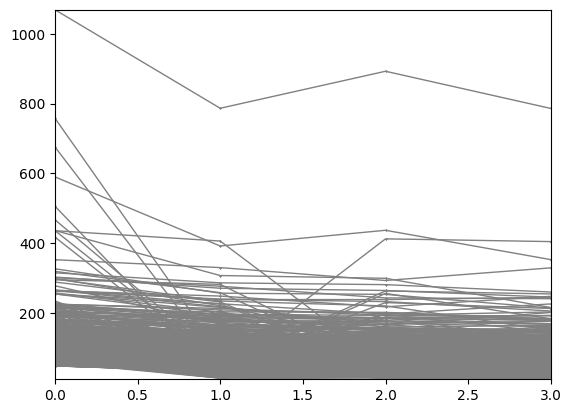

In [11]:
units_amplitudes = pd.read_csv('figure_data_RERUN_panels_GtoK/panel_E/unit_amplitude.csv').to_numpy()

for unit in range(len(units_amplitudes)): 
    plt.plot([0, 1, 2, 3], units_amplitudes[unit], c='grey', linewidth=1, marker = 'x', markersize=1)
plt.show()
plt.close()


In [109]:
units_amplitudes.shape

(1474, 4)

In [119]:
stats.ttest_ind(units_amplitudes[:, 0], units_amplitudes[:, 1])

(np.median(units_amplitudes[:, 0]) - np.median(units_amplitudes[:, 1])) / np.median(units_amplitudes[:, 0])

0.23184135893870594

In [120]:
stats.ttest_ind(units_amplitudes[:, 0], units_amplitudes[:, 2])

(np.median(units_amplitudes[:, 0]) - np.median(units_amplitudes[:, 2])) / np.median(units_amplitudes[:, 0])

0.32647380147871496

In [121]:
stats.ttest_ind(units_amplitudes[:, 0], units_amplitudes[:, 3])

(np.median(units_amplitudes[:, 0]) - np.median(units_amplitudes[:, 3])) / np.median(units_amplitudes[:, 0])

0.35385200239753745

In [113]:
units_amplitudes[:, 0].shap

(1474,)

In [124]:
# Get per-unit spread
data_names

['ZYE_0021___2021-05-01___1',
 'ZYE_0031___2021-12-03___1___p0_g0_imec0',
 'ZYE_0040___2021-08-15___3___p1_g0_imec0',
 'ZYE_0021___2021-05-01___4___p2_g0_imec0',
 'ZYE_0057___2022-02-07',
 'ZYE_0057___2022-02-04___1___p0_g0___p0_g0_imec0',
 'ZYE_0031___2021-12-01___1___p0_g0_imec0',
 'ZYE_0057___2022-02-07',
 'ZYE_0021___2021-05-01___4___p2_g0_imec0',
 'ZYE_0057___2022-02-04___1___p0_g0___p0_g0_imec0',
 'ZYE_0031___2021-12-02___4___p2_g0_imec0',
 'ZYE_0057___2022-02-03___2___p1_g0___p1_g0_imec0',
 'LK_0011___2021-12-06___1___p0_g0_imec0']

In [129]:
# Create csv with unit amplitudes

unit_x_spread_pat_1 = []
unit_x_spread_pat_2 = []
unit_x_spread_pat_3 = []
unit_x_spread_pat_4 = []
unit_z_spread_pat_1 = []
unit_z_spread_pat_2 = []
unit_z_spread_pat_3 = []
unit_z_spread_pat_4 = []

for name_recording, slice, pats, dir, pat_1_dir in tqdm(zip(data_names, slices_all, patterns, full_dir_list, pat_1_dir_list)):

    print(f"output of {name_recording}")

    dir = Path(dir)
    pat_1_dir = Path(pat_1_dir)

    subtraction_dir = pat_1_dir / f"{name_recording}_pat1/subtraction_results"
    
    sub_h5 = subtraction_dir / "subtraction.h5"
    motion_estimate_name = subtraction_dir / "motion_estimate.obj"
    filehandler =open(motion_estimate_name, 'rb') 
    me = pickle.load(filehandler)
    with h5py.File(sub_h5, "r+") as h5:
        times_samples = np.array(h5["times_samples"][:])
        times_seconds = np.array(h5["times_seconds"][:])
        
    labels = np.load(pat_1_dir / f"{name_recording}_pat1/initial_clustering/clustering_labels.npy")
    units = np.unique(labels)
    units = units[units>-1]
    
    for pat_reloc in pats:

        name_recording_pat = f"{name_recording}_pat{pat_reloc}"

        dir_pat = dir / name_recording_pat
        locs = np.load(dir_pat / "reloc_locations.npy")
        n_spikes = len(amplitudes)

        depth_reg = me.correct_s(times_seconds, locs[:, 2])

        for unit in units:
            if pat_reloc == 1:
                unit_x_spread_pat_1.append(mad(locs[labels == unit, 0]))
                unit_z_spread_pat_1.append(mad(depth_reg[labels == unit]))
            if pat_reloc == 2:
                unit_x_spread_pat_2.append(mad(locs[labels == unit, 0]))
                unit_z_spread_pat_2.append(mad(depth_reg[labels == unit]))
            if pat_reloc == 3:
                unit_x_spread_pat_3.append(mad(locs[labels == unit, 0]))
                unit_z_spread_pat_3.append(mad(depth_reg[labels == unit]))
            if pat_reloc == 4:
                unit_x_spread_pat_4.append(mad(locs[labels == unit, 0]))
                unit_z_spread_pat_4.append(mad(depth_reg[labels == unit]))


0it [00:00, ?it/s]

output of ZYE_0021___2021-05-01___1


1it [00:06,  6.71s/it]

output of ZYE_0031___2021-12-03___1___p0_g0_imec0


2it [00:26, 14.62s/it]

output of ZYE_0040___2021-08-15___3___p1_g0_imec0


3it [00:56, 21.41s/it]

output of ZYE_0021___2021-05-01___4___p2_g0_imec0


4it [00:56, 13.06s/it]

output of ZYE_0057___2022-02-07


5it [01:06, 12.07s/it]

output of ZYE_0057___2022-02-04___1___p0_g0___p0_g0_imec0


6it [01:11,  9.47s/it]

output of ZYE_0031___2021-12-01___1___p0_g0_imec0


7it [01:18,  8.69s/it]

output of ZYE_0057___2022-02-07


8it [01:19,  6.38s/it]

output of ZYE_0021___2021-05-01___4___p2_g0_imec0


9it [01:20,  4.62s/it]

output of ZYE_0057___2022-02-04___1___p0_g0___p0_g0_imec0


10it [01:23,  4.12s/it]

output of ZYE_0031___2021-12-02___4___p2_g0_imec0


11it [01:31,  5.31s/it]

output of ZYE_0057___2022-02-03___2___p1_g0___p1_g0_imec0


12it [01:49,  9.08s/it]

output of LK_0011___2021-12-06___1___p0_g0_imec0


13it [02:05,  9.63s/it]


In [125]:
def mad(x):
    mad = np.median(np.abs(x-np.median(x))) / 0.675
    return mad

In [130]:
list_of_tuples = list(zip(unit_x_spread_pat_1,
                         unit_x_spread_pat_4, 
                         unit_x_spread_pat_3,
                         unit_x_spread_pat_2,
                         unit_z_spread_pat_1,
                         unit_z_spread_pat_4,
                         unit_z_spread_pat_3,
                         unit_z_spread_pat_2))

# # Assign data to tuples.
# list_of_tuples


# Converting lists of tuples into
# pandas Dataframe.
df = pd.DataFrame(list_of_tuples,
                  columns=['spread x full',	'spread x LD', 'spread x NP2', 'spread x NP1', 
                           'spread z full', 'spread z LD', 'spread z NP2', 'spread z NP1'])

print(df)

      spread x full  spread x LD  spread x NP2  spread x NP1  spread z full  \
0          0.817109     2.149988      0.712061      1.458372      19.255020   
1          0.237686     0.446777      0.429371      1.077718       5.542598   
2          0.212382     0.764591      0.304929      0.617955       4.666542   
3          1.989750     2.389618      5.122075      2.485755      12.035836   
4          0.613684     1.046513      0.621861      1.367359      13.223057   
...             ...          ...           ...           ...            ...   
1469      20.504165    13.190416      7.296761     16.998788      19.124469   
1470      22.213656    21.806937     18.062612     25.312593      13.350026   
1471      17.275702    17.976181     16.650151     21.324408      14.842550   
1472      14.698917    15.763343     17.291327     20.255550      15.349109   
1473      16.692920    18.377576     15.572480     23.269523      15.775866   

      spread z LD  spread z NP2  spread z NP1  
0  

In [131]:
df.to_csv('figure_data_RERUN_panels_GtoK/panel_G/spread_x_z.csv', index=False)  

In [158]:
# Example of statistical z test

stats.ttest_ind(units_spreads[:, 0], units_spreads[:, 3])


TtestResult(statistic=-5.545197969514962, pvalue=3.196095710462056e-08, df=2946.0)

In [5]:
# Create csv with unit SNR

unit_SNR_pat_1 = []
unit_SNR_pat_2 = []
unit_SNR_pat_3 = []
unit_SNR_pat_4 = []

for name_recording, slice in tqdm(zip(data_names, slices_all)):

    print(f"output of {name_recording}")

    for pat_reloc in pats:

        name_recording_pat = f"{name_recording}_pat{pat_reloc}"

        dir_pat = dir / name_recording_pat
        snrs = np.load(dir_pat / "template_SNR.npy")

        if pat_reloc == 1:
            unit_SNR_pat_1.append(snrs)
        if pat_reloc == 2:
            unit_SNR_pat_2.append(snrs)
        if pat_reloc == 3:
            unit_SNR_pat_3.append(snrs)
        if pat_reloc == 4:
            unit_SNR_pat_4.append(snrs)


13it [00:00, 870.52it/s]

output of ZYE_0021___2021-05-01___1
output of ZYE_0031___2021-12-03___1___p0_g0_imec0
output of ZYE_0040___2021-08-15___3___p1_g0_imec0
output of ZYE_0021___2021-05-01___4___p2_g0_imec0
output of ZYE_0057___2022-02-07
output of ZYE_0057___2022-02-04___1___p0_g0___p0_g0_imec0
output of ZYE_0031___2021-12-01___1___p0_g0_imec0
output of ZYE_0057___2022-02-07
output of ZYE_0021___2021-05-01___4___p2_g0_imec0
output of ZYE_0057___2022-02-04___1___p0_g0___p0_g0_imec0
output of ZYE_0031___2021-12-02___4___p2_g0_imec0
output of ZYE_0057___2022-02-03___2___p1_g0___p1_g0_imec0
output of LK_0011___2021-12-06___1___p0_g0_imec0


In [7]:
list_of_tuples = list(zip(np.concatenate(unit_SNR_pat_1), np.concatenate(unit_SNR_pat_4), np.concatenate(unit_SNR_pat_3), np.concatenate(unit_SNR_pat_2)))

# # Assign data to tuples.
# list_of_tuples


# Converting lists of tuples into
# pandas Dataframe.
df = pd.DataFrame(list_of_tuples,
                  columns=['unit amp full', 'unit amp LD', 'unit amp NP2', 'unit amp NP1'])

print(df)

      unit amp full  unit amp LD  unit amp NP2  unit amp NP1
0         47.405060    69.394323     44.763484     64.733935
1        845.630586   688.557620    619.726723    324.799160
2        153.775811   244.303374    255.575298    205.052103
3         23.644786    29.902696     30.045846     50.813527
4         85.563798   136.288951    129.458452    221.005870
...             ...          ...           ...           ...
1469            NaN          NaN           NaN           NaN
1470      27.387458    27.093613     19.547628     24.376151
1471      45.314013    21.352116     45.656146     25.092743
1472      99.814295    73.620745     53.209836     46.634552
1473      17.770590    21.366165     51.417153     20.895451

[1474 rows x 4 columns]


In [8]:
df.to_csv('figure_data_RERUN_panels_GtoK/panel_F/all_templates_snr.csv', index=False)  

In [ ]:
units_snrs = pd.read_csv('figure_data_RERUN_panels_GtoK/panel_F/all_templates_snr.csv').to_numpy()
